In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

import pandas as pd
import baostock as bs
from utils import get_index_components, get_csindex_components, get_history_k
import warnings
warnings.filterwarnings('ignore')



In [11]:
df_market = get_history_k(['sh.000001'],'2010-01-01','2024-12-25')

login success!
logout success!


In [28]:
# 适配prophet的变量名
# df_market['ds'] = pd.date_range(start='2000-01-01', periods=df_market.shape[0], freq='D').astype(str)
df_market['ds'] = df_market['date'].astype(str)
df_market['y'] = df_market['close']
df_market.tail(5)

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pct_chg,pe_ttm,ps_ttm,pcf_ncf_ttm,pb_mrq,is_st,ds,y
3634,2024-12-19,sh.000001,3355.9041,3377.5321,3346.4690,3370.0331,3382.2081,51390906300,5.591310e+11,3,1.115742,1,-0.359972,0.0,0.0,0.0,0.0,0.0,2024-12-19,3370.0331
3635,2024-12-20,sh.000001,3364.4810,3390.6182,3362.8193,3368.0693,3370.0331,49096462100,5.968219e+11,3,1.065912,1,-0.058272,0.0,0.0,0.0,0.0,0.0,2024-12-20,3368.0693
3636,2024-12-23,sh.000001,3367.9037,3384.9918,3348.2770,3351.2571,3368.0693,55674724800,6.231178e+11,3,1.208029,1,-0.499164,0.0,0.0,0.0,0.0,0.0,2024-12-23,3351.2571
3637,2024-12-24,sh.000001,3353.5354,3394.9044,3352.9474,3393.5281,3351.2571,47199267300,5.307580e+11,3,1.024014,1,1.261348,0.0,0.0,0.0,0.0,0.0,2024-12-24,3393.5281
3638,2024-12-25,sh.000001,3395.1072,3406.2125,3374.0113,3393.3501,3393.5281,47131559200,5.221682e+11,3,1.022492,1,-0.005245,0.0,0.0,0.0,0.0,0.0,2024-12-25,3393.3501


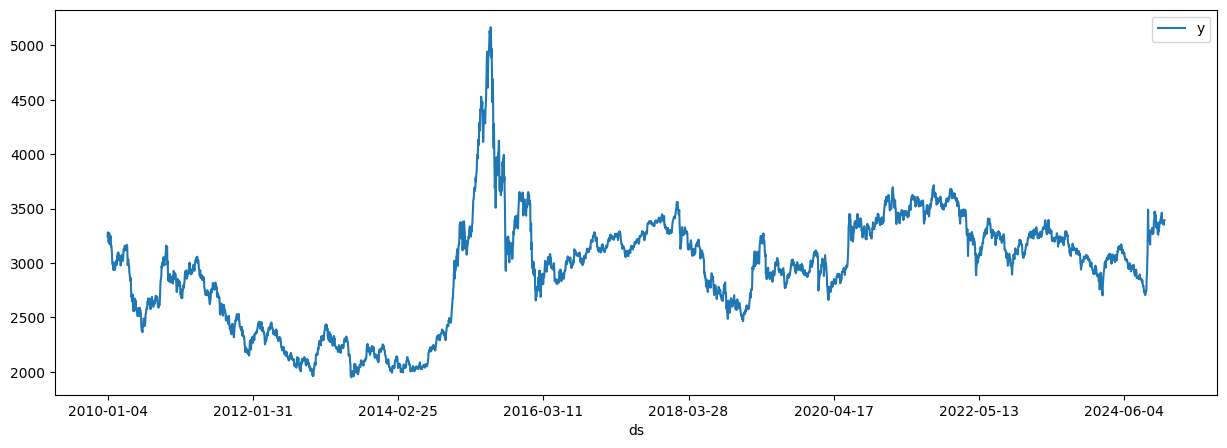

In [70]:
df = df_market[['ds','y','turn']]
plt = df.plot(x="ds", y="y", figsize=(15, 5))

In [35]:
?NeuralProphet

Init signature:
NeuralProphet(
    growth: Literal['off', 'linear', 'discontinuous'] = 'linear',
    changepoints: Union[list, NoneType] = None,
    n_changepoints: int = 10,
    changepoints_range: float = 0.8,
    trend_reg: float = 0,
    trend_reg_threshold: Union[bool, float, NoneType] = False,
    trend_global_local: str = 'global',
    yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto',
    weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto',
    daily_seasonality: Union[Literal['auto'], bool, int] = 'auto',
    seasonality_mode: Literal['additive', 'multiplicative'] = 'additive',
    seasonality_reg: float = 0,
    season_global_local: Literal['global', 'local'] = 'global',
    n_forecasts: int = 1,
    n_lags: int = 0,
    num_hidden_layers: int = 0,
    d_hidden: Union[int, NoneType] = None,
    ar_reg: Union[float, NoneType] = None,
    learning_rate: Union[float, NoneType] = None,
    epochs: Union[int, NoneType] = None,
    batch_size: Union[int, Non

In [89]:
?m.make_future_dataframe

Signature:
m.make_future_dataframe(
    df: pandas.core.frame.DataFrame,
    events_df: Union[pandas.core.frame.DataFrame, NoneType] = None,
    regressors_df: Union[pandas.core.frame.DataFrame, NoneType] = None,
    periods: Union[int, NoneType] = None,
    n_historic_predictions: Union[bool, int] = False,
)
Docstring:
Extends dataframe a number of periods (time steps) into the future.

Only use if you predict into the *unknown* future.
New timestamps are added to the historic dataframe, with the 'y' column being NaN, as it remains to be predicted.
Further, the given future events and regressors are added to the periods new timestamps.
The returned dataframe will include historic data needed to additionally produce `n_historic_predictions`,
for which there are historic observances of the series 'y'.

Parameters
----------
    df: pd.DataFrame
        History to date. DataFrame containing all columns up to present
    events_df : pd.DataFrame
        Future event occurrences correspond

In [107]:
df_train = df[df['ds']<'2024-12-01']
df_eval = df[df['ds']>='2024-11-15']

m = NeuralProphet(n_changepoints=0, n_lags=10, quantiles=[0.1,0.9], newer_samples_weight=1.1, n_forecasts=5)
m.add_lagged_regressor("turn", n_lags=3)

m.set_plotting_backend("plotly")

metrics = m.fit(df_train, freq='D')



Finding best initial lr:   0%|          | 0/243 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [115]:
m.highlight_nth_step_ahead_of_each_forecast(step_number=5)

df_future = m.make_future_dataframe(df_train, n_historic_predictions=True, periods=365)

forecast = m.predict(df_eval)

m.plot(forecast, forecast_in_focus=5, figsize=(12,5))

Predicting: 170it [00:00, ?it/s]

In [109]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat1 10.0%,yhat2 10.0%,yhat3 10.0%,...,ar4,ar5,lagged_regressor_turn1,lagged_regressor_turn2,lagged_regressor_turn3,lagged_regressor_turn4,lagged_regressor_turn5,trend,season_yearly,season_weekly
0,2024-11-15,3330.726300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-16,3328.433733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-11-17,3326.141167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-11-18,3323.848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-19,3346.009800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-11-20,3367.989300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-11-21,3370.403900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-11-22,3267.191600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-11-23,3266.047633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-11-24,3264.903667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
m.plot_parameters(components=["trend", "seasonality", 'autoregression'])

In [69]:
# evaluate uncertainy on calibration set
train_df, cal_df = m.split_df(df, valid_p=0.1)
method = "naive"  # or "cqr" for a more sophisticated method, see uncertainty tutorial
conformal_forecast = m.conformal_predict(train_df, cal_df, alpha=0.1, method=method)
m.highlight_nth_step_ahead_of_each_forecast(1).plot(conformal_forecast)

Predicting: 122it [00:00, ?it/s]

Predicting: 122it [00:00, ?it/s]